# Описание проекта
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
# Цель проекта
- Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.
# Описание данных


 - `market_file.csv`:
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

  - `id` — номер покупателя в корпоративной базе данных.
  
  - `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
  
  - `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
  
  - `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
  
  - `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
  
  - `Маркет_актив_тек_ме`с — количество маркетинговых коммуникаций в текущем месяце.
  
  - `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
  
  - `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
  
  - `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
  
  - `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
  
  - `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
  
  - `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
  
  - `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.


 - `market_money.csv`:
Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
  - `id` — номер покупателя в корпоративной базе данных.
  
  - `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
  
  - `Выручка` — сумма выручки за период.


 - `market_time.csv`:
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
  - `id` — номер покупателя в корпоративной базе данных.
  
  - `Период` — название периода, во время которого зафиксировано общее время.
минут — значение времени, проведённого на сайте, в минутах.


 - `money.csv`:
Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
  - `id` — номер покупателя в корпоративной базе данных.
  
  - `Прибыль` — значение прибыли.

# Шаг 1. Загрузка данных

Импортируем необходимые библиотеки, классы, методы и тд.

In [1]:
pip install --upgrade scikit-learn

     |████████████████████████████████| 13.4 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 95.1 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install optuna-integration
!pip install phik
!pip install shap

     |████████████████████████████████| 96 kB 2.1 MB/s eta 0:00:011
     |████████████████████████████████| 362 kB 13.6 MB/s eta 0:00:01
     |████████████████████████████████| 686 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 539 kB 2.2 MB/s eta 0:00:01


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
from phik.report import plot_correlation_matrix
import shap
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score,
                                     RandomizedSearchCV)

from sklearn.preprocessing import (OneHotEncoder,
                                   LabelEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler)
from sklearn.metrics import (roc_auc_score,
                             accuracy_score)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

Прочитаем датасеты и сохраним их в переменные

In [4]:
market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv', decimal=',')
market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv', decimal=',')
market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv', decimal=',')
money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',')
display(market_file.head())
display(market_money.head())
display(market_time.head())
display(money.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


# Загрузка данных. Промежуточный вывод:
 - Загрузил датасеты и сохранил их в переменные:
   - `market_file` - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
   
   - `market_time` - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
   
   - `market_money` - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
   
   - `money` - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
   
   - В датасете `market_file` столбцы: `Покупательская активность`, `Тип сервиса` и `Разрешить сообщать` отличаются от общего стиля, исправим в процессе предобработки данных
 - Данные в таблицах соответсвуют их описанию

# Шаг 2. Предобработка данных

Создадим функцию которая приведет названия столбцов к нижнему регистру

In [5]:
def low(data):
    data.columns = data.columns.str.lower()
    return data

In [6]:
low(market_file)
low(market_money)
low(market_time)
low(money)
display(market_file.head())
display(market_money.head())
display(market_time.head())
display(money.head())

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Приведем столбцы: `покупательская активность`, `тип сервиса` и `разрешить сообщать` к единому стилю: "змеиному_регистру"

In [7]:
market_file.rename(columns={'покупательская активность':'покупательская_активность',
                    'тип сервиса':'тип_сервиса',
                    'разрешить сообщать':'разрешить_сообщать'}, inplace=True)

Для удобства приведем к нижнему регистру значения в столбцах - `покупательская_активность` и `популярная_категория` датасета `market_file`

In [8]:
market_file['покупательская_активность'] = market_file['покупательская_активность'].str.lower()
market_file['популярная_категория'] = market_file['популярная_категория'].str.lower()
market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,снизилась,премиум,да,3.4,5,121,0.0,товары для детей,6,2,1,5
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5
2,215350,снизилась,стандартт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5
3,215351,снизилась,стандартт,да,3.2,5,896,0.99,товары для детей,5,0,6,4
4,215352,снизилась,стандартт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2


Посмотрим на общую информацию, типы данных, пропуски и дубликаты в датасетах 

In [9]:
def rep(data):
    return data.info(), data.isna().sum()

Посмотрим на датасет `market_file`

In [10]:
rep(market_file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   1300 non-null   int64 
 1   покупательская_активность            1300 non-null   object
 2   тип_сервиса                          1300 non-null   object
 3   разрешить_сообщать                   1300 non-null   object
 4   маркет_актив_6_мес                   1300 non-null   object
 5   маркет_актив_тек_мес                 1300 non-null   int64 
 6   длительность                         1300 non-null   int64 
 7   акционные_покупки                    1300 non-null   object
 8   популярная_категория                 1300 non-null   object
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64 
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64 
 11  ошибка_сервиса                       1300 n

(None,
 id                                     0
 покупательская_активность              0
 тип_сервиса                            0
 разрешить_сообщать                     0
 маркет_актив_6_мес                     0
 маркет_актив_тек_мес                   0
 длительность                           0
 акционные_покупки                      0
 популярная_категория                   0
 средний_просмотр_категорий_за_визит    0
 неоплаченные_продукты_штук_квартал     0
 ошибка_сервиса                         0
 страниц_за_визит                       0
 dtype: int64)

In [11]:
market_file.duplicated().sum()

0

В датасете `market_file` обнаружены неподходящие типы данных в столбцах: `маркет_актив_6_мес` и `акционные_покупки`, изменим их на тип `float`

In [12]:
market_file[['акционные_покупки', 'маркет_актив_6_мес']] = market_file[
    ['акционные_покупки', 'маркет_актив_6_мес']
].astype('float')
rep(market_file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

(None,
 id                                     0
 покупательская_активность              0
 тип_сервиса                            0
 разрешить_сообщать                     0
 маркет_актив_6_мес                     0
 маркет_актив_тек_мес                   0
 длительность                           0
 акционные_покупки                      0
 популярная_категория                   0
 средний_просмотр_категорий_за_визит    0
 неоплаченные_продукты_штук_квартал     0
 ошибка_сервиса                         0
 страниц_за_визит                       0
 dtype: int64)

In [13]:
market_file.duplicated().sum()

0

В датасете `market_file` пропусков и явных дубликатов не обнаружено

Посмотрим на датасет `market_money`

In [14]:
rep(market_money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3900 non-null   int64 
 1   период   3900 non-null   object
 2   выручка  3900 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.5+ KB


(None,
 id         0
 период     0
 выручка    0
 dtype: int64)

Обнаружен неподходящий тип данных в столбце `выручка`, изменим тип данных на `float`

In [15]:
market_money['выручка'] = market_money['выручка'].astype('float')
rep(market_money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


(None,
 id         0
 период     0
 выручка    0
 dtype: int64)

In [16]:
market_money.duplicated().sum()

0

В датасете `market_money` пропусков и явных дубликатов не обнаружено

Посмотрим на датасет `market_time`

In [17]:
rep(market_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


(None,
 id        0
 период    0
 минут     0
 dtype: int64)

In [18]:
market_time.duplicated().sum()

0

В датасете `market_time` пропусков и явных дубликатов не обнаружено

Посмотрим на датасет `money`

In [19]:
rep(money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


(None,
 id         0
 прибыль    0
 dtype: int64)

In [20]:
money.duplicated().sum()

0

В датасете `money` пропусков и явных дубликатов не обнаружено

Посмотрим на уникальные значения
 - Напишем функцию где будем перебирать все столбцы, кроме тех что укажем в дополнительном аргументе
 - Поочередно применим функцию к датасетам

In [21]:
def uniq(data, columns):
    for name, values in data.drop(columns, axis=1).iteritems():
        print(name, values.unique())

In [22]:
uniq(market_file, columns=['id', 'маркет_актив_6_мес',
                                      'маркет_актив_тек_мес', 'длительность', 
                                     'акционные_покупки'])

покупательская_активность ['снизилась' 'прежний уровень']
тип_сервиса ['премиум' 'стандартт' 'стандарт']
разрешить_сообщать ['да' 'нет']
популярная_категория ['товары для детей' 'домашний текстиль' 'косметика и аксесуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']
средний_просмотр_категорий_за_визит [6 4 5 3 2 1]
неоплаченные_продукты_штук_квартал [ 2  4  0  1  3  5  8  6  9 10  7]
ошибка_сервиса [1 2 6 3 7 9 4 5 8 0]
страниц_за_визит [ 5  4  2  3  7  1  6  8  9 14 11 15 16 10 17 13 12 18 19 20]


В датасете `market_file` в столбце `тип_сервиса` обнаружена ошибка в категории - `стандартт` изменим на `стандарт`

In [23]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].str.replace('стандартт','стандарт')
market_file['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [24]:
uniq(market_money, columns=['id', 'выручка'])

период ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [25]:
uniq(market_time, columns=['id'])

период ['текущий_месяц' 'предыдцщий_месяц']
минут [14 13 10 12  8 11  6  7  9  5 15  4 16 17 19 18 22 20 21 23]


В датасете `market_time` в значении столбца `период` ошибка, исправим

In [26]:
market_time['период'] = market_time['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')
uniq(market_time, columns=['id'])

период ['текущий_месяц' 'предыдущий_месяц']
минут [14 13 10 12  8 11  6  7  9  5 15  4 16 17 19 18 22 20 21 23]


In [27]:
uniq(money, columns='id')

прибыль [0.98 4.16 3.13 4.87 4.21 3.95 3.62 5.26 4.93 4.66 3.06 5.08 4.55 4.03
 3.49 1.83 2.67 3.65 2.95 3.03 6.27 3.86 2.82 1.4  1.63 3.69 4.08 4.18
 4.26 4.27 4.42 3.88 2.42 4.78 4.85 4.05 3.48 5.16 4.6  5.7  5.44 4.1
 2.93 3.9  3.28 5.09 3.19 4.77 5.01 6.73 7.43 4.28 3.73 3.38 3.47 5.
 2.02 3.68 2.68 4.46 2.41 5.4  3.4  4.22 4.5  4.98 3.96 3.18 4.65 3.92
 3.89 5.64 2.76 4.25 3.71 4.63 2.97 3.24 3.81 4.04 6.33 4.68 3.6  3.04
 4.41 3.98 2.47 4.52 4.01 5.31 2.53 5.83 4.48 2.98 4.92 3.08 4.9  3.94
 2.99 4.62 3.76 3.42 4.17 4.47 4.69 4.59 2.84 3.66 4.97 2.19 2.74 5.41
 4.12 3.93 5.02 3.52 3.39 6.12 4.64 3.14 4.71 4.99 3.74 4.   5.23 2.08
 6.55 2.36 4.32 3.15 2.77 5.56 3.44 3.58 2.92 4.67 3.33 2.94 1.06 2.45
 4.86 5.05 3.2  2.8  4.13 1.81 2.79 4.11 2.55 3.84 3.17 4.51 3.45 3.27
 4.2  4.33 3.01 5.79 3.12 6.59 6.88 2.7  2.69 5.49 2.34 5.25 3.25 4.74
 3.77 4.34 5.06 4.95 3.1  4.14 3.3  3.99 2.6  4.31 2.96 4.19 5.12 5.35
 4.29 4.61 2.29 4.43 5.99 5.04 3.55 2.59 2.57 4.36 3.87 3.91 3.54 4.94
 

# Предобработка данных. Промежуточный вывод:
 - В процессе предобработки данных было сделано:
   - Привел все столбцы в датасетах к нижнему "змеиному регистру"
   - Для удобства привел к нижнему регистру значения в столбцах - `покупательская_активность` и `популярная_категория` датасета `market_file`
   - Проверил во всех датасетах пропуски, дубликаты, типы данных:
     - В датасете `market_file` обнаружены неподходящие типы данных в столбцах: `маркет_актив_6_мес` и `акционные_покупки`, изменил их на тип `float`
     - В датасете `market_money` обнаружен неподходящий тип данных в столбце `выручка`, изменил тип данных на `float`
     - В во всех датасетах не обнаружено пропусков и дубликатов
   - Проверил уникальные значения в каждом столбце каждого датасета:
     - Были проверены в основном категориальные столбцы и колличественные с небольшим числом уникальных значений, так как эти значения мы проверим на шаге исследовательского анализа данных
     - В датасете `market_file` в столбце `тип_сервиса` обнаружена ошибка в категории - `стандартт` изменил на `стандарт`
     - В датасете `market_time` в значении столбца `период` обнаружена орфографическая ошибка, исправил

# Шаг 3. Исследовательский анализ данных

Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период

In [28]:
drop_client = market_money.query('выручка == 0.0')
drop_client

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Найдено 3 клиента с покупателькской активностью менее трех месяцев

In [29]:
drop_client = list(drop_client['id'])

In [30]:
drop_client

[215348, 215348, 215357, 215357, 215359, 215359]

Удалим этих клиентов из всех датасетов

In [31]:
market_file = market_file[~market_file['id'].isin(drop_client)]
market_file.reset_index(drop=True, inplace=True)
market_file[market_file['id'].isin(drop_client)]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит


In [32]:
market_time = market_time[~market_time['id'].isin(drop_client)]
market_time.reset_index(drop=True, inplace=True)
market_time[market_time['id'].isin(drop_client)]

,id,период,минут


In [33]:
market_money = market_money[~market_money['id'].isin(drop_client)]
market_money.reset_index(drop=True, inplace=True)
market_money[market_money['id'].isin(drop_client)]

,id,период,выручка


In [34]:
money = money[~money['id'].isin(drop_client)]
money.reset_index(drop=True, inplace=True)
money[money['id'].isin(drop_client)]

,id,прибыль


Приступим к исследовательскому анализу данных:
 - Посмотрим числовые значения методом `describe()`
 - Построим для каждого столбца подходящие графики

### Исследовательский анализ датасета `market_file`

Напишу функцию которая будет считать количество категорий и строить круговую диагрумму с распределением в процентном соотношении

In [35]:
def pie(data):
    plt = (
        data.value_counts().plot(
            kind='pie',
            y=data,
            autopct='%1.0f%%',
            figsize=(8,8),
            legend=True)
    ),
    count_ = data.value_counts()
    return plt, count_

Посмотрим на распределние столбца `покупательская_активность`

((<AxesSubplot:ylabel='покупательская_активность'>,),
 прежний уровень    802
 снизилась          495
 Name: покупательская_активность, dtype: int64)

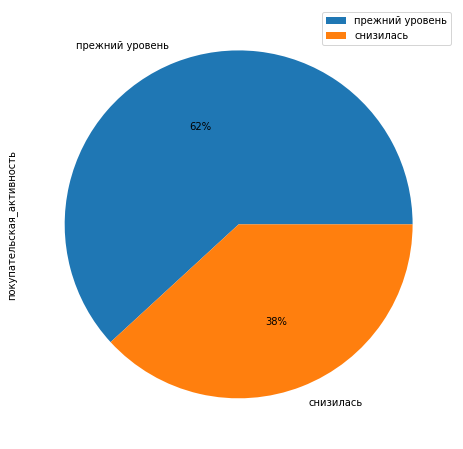

In [36]:
pie(market_file['покупательская_активность'])

В столбце `покупательская_активность`:
 - В категории `снизилась` - 495 клиентов (38%)
 - В категории `прежний уровень` - 802 клента (62%)

Посмотрим на распределние столбца `тип_сервиса`

((<AxesSubplot:ylabel='тип_сервиса'>,),
 стандарт    922
 премиум     375
 Name: тип_сервиса, dtype: int64)

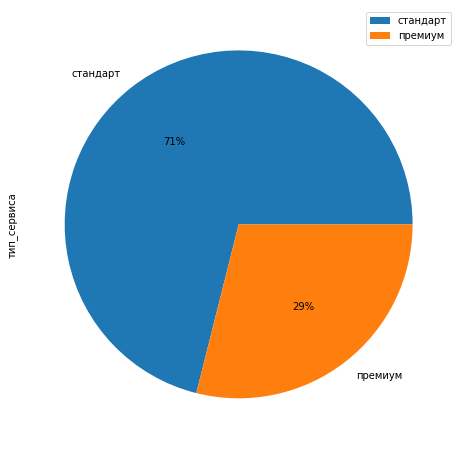

In [37]:
pie(market_file['тип_сервиса'])

В столбце `тип_сервиса`:
 - В категории `стандарт` - 922 клиента (71%)
 - В категории `премиум` - 375 клентов (29%)

((<AxesSubplot:ylabel='разрешить_сообщать'>,),
 да     959
 нет    338
 Name: разрешить_сообщать, dtype: int64)

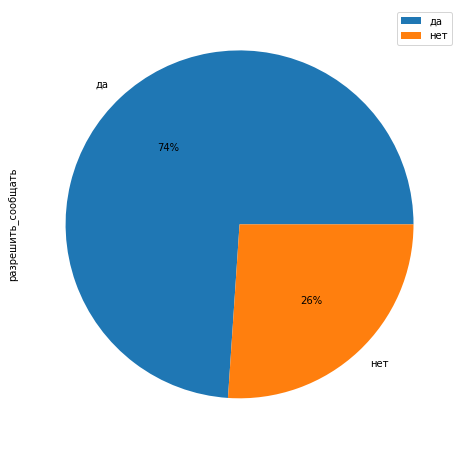

In [38]:
pie(market_file['разрешить_сообщать'])

В столбце `разрешить_сообщать`:
 - В категории `да` - 959 клиентов (74%)
 - В категории `нет` - 338 клентов (26%)

Проведем анализ столбца `маркет_актив_6_мес`

In [39]:
market_file['маркет_актив_6_мес'].describe()

count    1297.000000
mean        4.254433
std         1.015618
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64

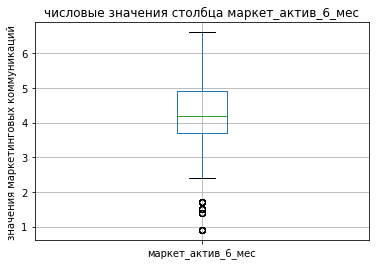

In [40]:
market_file.boxplot(column='маркет_актив_6_мес')
plt.title('числовые значения столбца маркет_актив_6_мес')
plt.ylabel('значения маркетинговых коммуникаций')
plt.show()

В столбце `маркет_актив_6_мес`:
 - Среднее - 4.25
 - Медиана - 4.20
 - Есть несколько выбросов 
 - Среднее и медиана близки друг к другу, а значит выбросы не так сильно влияют

Проведем анализ столбца `маркет_актив_тек_мес`

In [41]:
market_file['маркет_актив_тек_мес'].describe()

count    1297.000000
mean        4.009252
std         0.696048
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64

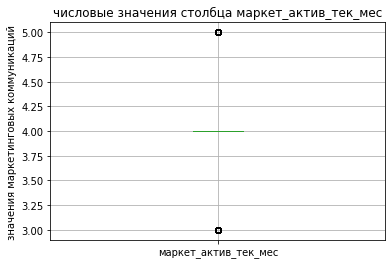

In [42]:
market_file.boxplot(column='маркет_актив_тек_мес')
plt.title('числовые значения столбца маркет_актив_тек_мес')
plt.ylabel('значения маркетинговых коммуникаций')
plt.show()

В столбце `маркет_актив_тек_мес`:
 - Среднее - 4.009
 - Медиана - 4.0
 - Есть выбросы не при их удалении мы лишаемся почти половины данных, оставим без изменений, к тому же они почти не влияют на среднее по сравненнию с медианой

Проведем анализ столбца `длительность`

In [43]:
market_file['длительность'].describe()

count    1297.000000
mean      602.993832
std       249.101456
min       121.000000
25%       410.000000
50%       607.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64

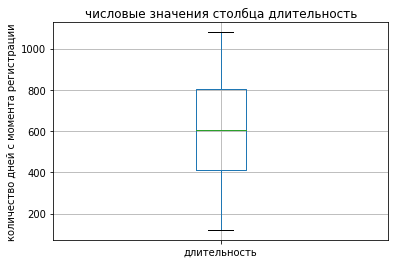

In [44]:
market_file.boxplot(column='длительность')
plt.title('числовые значения столбца длительность')
plt.ylabel('количество дней с момента регистрации')
plt.show()

В столбце `длительность`:
 - Среднее - 602.99
 - Медиана - 607.00
 - Выбросов и аномалий не обнаружено
 - Время с момента регистриации клиента на сайте показывает что в сервисе уже полгода нет новых пользователей

Проведем анализ столбца `акционные_покупки`

In [45]:
market_file['акционные_покупки'].describe()

count    1297.000000
mean        0.320547
std         0.249657
min         0.110000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64

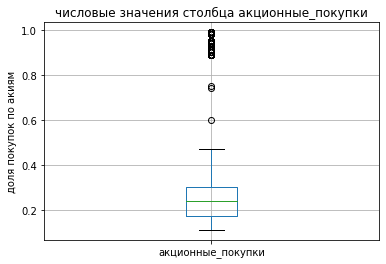

In [46]:
market_file.boxplot(column='акционные_покупки')
plt.title('числовые значения столбца акционные_покупки')
plt.ylabel('доля покупок по акиям')
plt.show()

В столбце `акционные_покупки`:
 - Есть выбросы, но думаю их оставить так как люди часто покупают товары по скидкам и акциям, к тому же на сервисе может быть много акционных предложений
 - Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев в основном составляет примерно 20%

Посмотрим на распределние значений `популярная_категория`

((<AxesSubplot:ylabel='популярная_категория'>,),
 товары для детей                        329
 домашний текстиль                       250
 косметика и аксесуары                   223
 техника для красоты и здоровья          183
 мелкая бытовая техника и электроника    174
 кухонная посуда                         138
 Name: популярная_категория, dtype: int64)

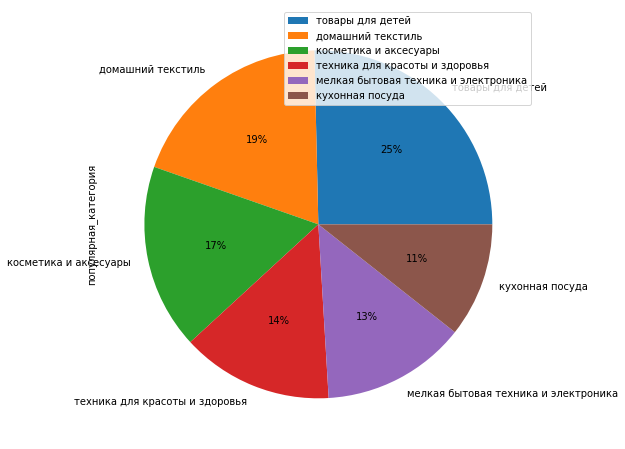

In [47]:
pie(market_file['популярная_категория'])

Напишем функцию для построения столбчатого графика

In [48]:
def barh(data, column):
    bar = (
        data.groupby(column)
        [column].count().sort_values().plot(
        kind='barh', figsize=(10,8), title= f'распределние количества по категориям в столбце: {column}')
    )
    xlabel=('количество')
    return bar

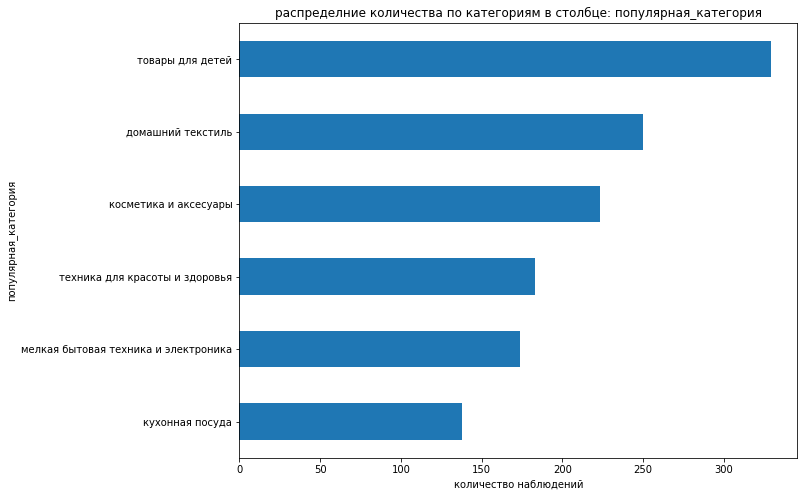

In [49]:
barh(market_file, column='популярная_категория')
plt.xlabel('количество наблюдений')
plt.show()

В столбце `популярная_категория`:
 - Категория - `товары дял детей`, самая популярная - 329 (25%)
 
 - Категория - `домашний текстиль`, в количестве - 250 (19%)
 
 - Категория - `косметика и аксессуары`, в количестве - 223 (17%)
 
 - Категория - `техника для красоты и здоровья`, в количестве - 183 (14%)
 
 - Категория - `мелкая бытовая техника и электроника`, в количестве - 174 (13%)
 
 - Категория - `кухонная посуда`, в количестве - 138 (11%)

Проведем анализ значений в столбце `средний_просмотр_категорий_за_визит`

In [50]:
market_file['средний_просмотр_категорий_за_визит'].describe()

count    1297.000000
mean        3.267540
std         1.354623
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: средний_просмотр_категорий_за_визит, dtype: float64

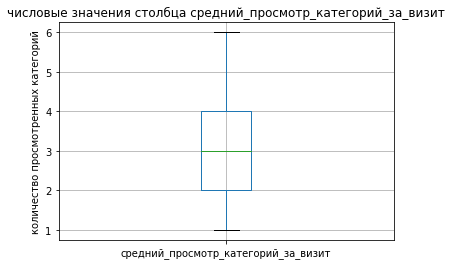

In [51]:
market_file.boxplot(column='средний_просмотр_категорий_за_визит')
plt.title('числовые значения столбца средний_просмотр_категорий_за_визит')
plt.ylabel('количество просмотренных категорий')
plt.show()

Рассмотрим столбец `средний_просмотр_категорий_за_визит` как категорильный

((<AxesSubplot:ylabel='средний_просмотр_категорий_за_визит'>,),
 3    355
 2    312
 4    262
 5    177
 1    106
 6     85
 Name: средний_просмотр_категорий_за_визит, dtype: int64)

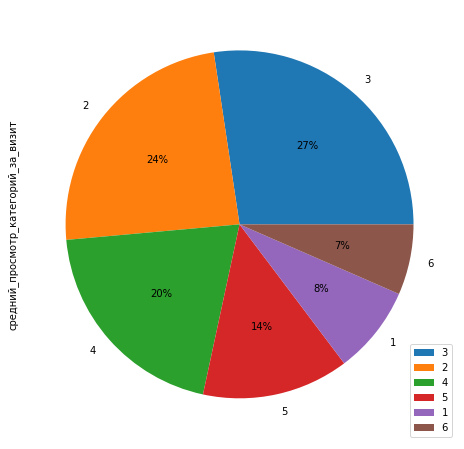

In [52]:
pie(market_file['средний_просмотр_категорий_за_визит'])

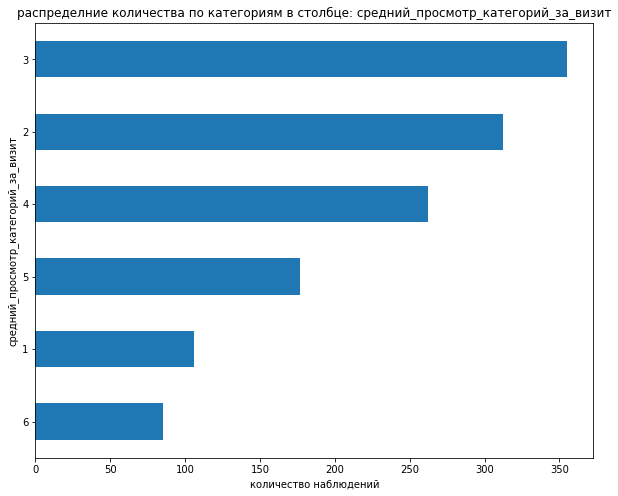

In [53]:
barh(market_file, column='средний_просмотр_категорий_за_визит')
plt.xlabel('количество наблюдений')
plt.show()

В течении последнего месяца, в среднем клиенты просматривают от 2 до 5 категорий за визит

Проведем анализ столбца `неоплаченные_продукты_штук_квартал`

In [54]:
market_file['неоплаченные_продукты_штук_квартал'].describe()

count    1297.000000
mean        2.841172
std         1.973451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

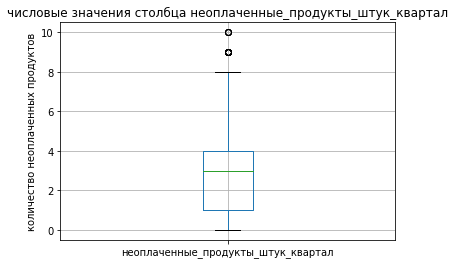

In [55]:
market_file.boxplot(column='неоплаченные_продукты_штук_квартал')
plt.title('числовые значения столбца неоплаченные_продукты_штук_квартал')
plt.ylabel('количество неоплаченных продуктов')
plt.show()

За последние 3 месяца большинство клиентов не оплатили 3 товара в корзине
 - Имеются выбросы, пока оставим

Проведем анализ столбца `ошибка_сервиса`

In [56]:
market_file['ошибка_сервиса'].describe()

count    1297.000000
mean        4.184271
std         1.950973
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64

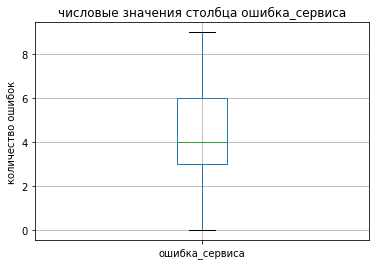

In [57]:
market_file.boxplot(column='ошибка_сервиса')
plt.title('числовые значения столбца ошибка_сервиса')
plt.ylabel('количество ошибок')
plt.show()

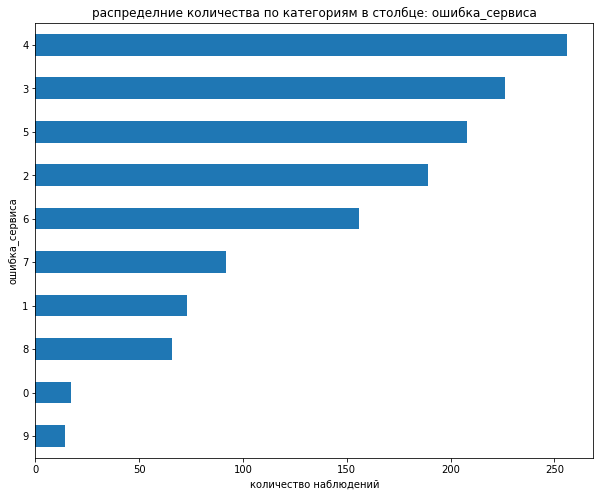

In [58]:
barh(market_file, column='ошибка_сервиса')
plt.xlabel('количество наблюдений')
plt.show()

В столбце `ошибка_сервиса`:
 - У большинства клиентов число сбоев от 2 до 6
 - Выбросов и аномалий не обнаружено

Проведем анализ столбца `страниц_за_визит`

In [59]:
market_file['страниц_за_визит'].describe()

count    1297.000000
mean        8.186584
std         3.977061
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64

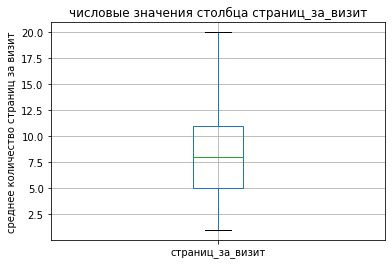

In [60]:
market_file.boxplot(column='страниц_за_визит')
plt.title('числовые значения столбца страниц_за_визит')
plt.ylabel('среднее количество страниц за визит')
plt.show()

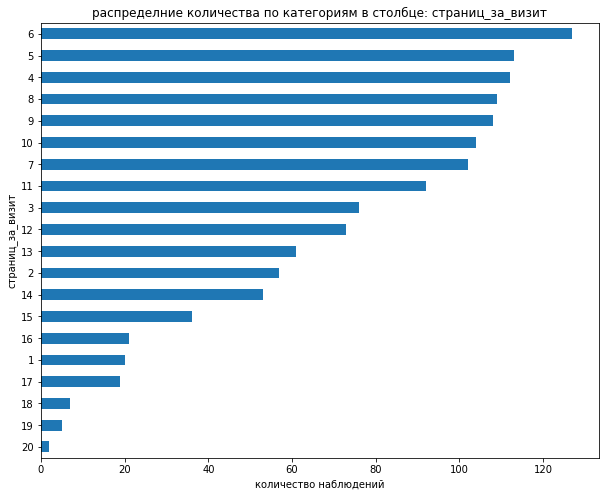

In [61]:
barh(market_file, column='страниц_за_визит')
plt.xlabel('количество наблюдений')
plt.show()

В основном клиенты просматривают от 3 до 12 странниц за визит

## Исследовательский анализ датасета `market_file`. Промежуточный вывод:
 - Убрали из всех датасетов клиентов с покупательской активностью менее трёх месяцев, то есть таких, которые не покупали в периоды - предыдущий_месяц и предпредыдущий_месяц
 - Провел исследовательский анализ по каждому столбцу:
  - Проверял числовые значения, распределения количества, процентные соотношения по категориям
 - Столбец `покупательская_активность`:
   - В категории `снизилась` - 495 клиентов (38%)
   - В категории `прежний уровень` - 802 клента (62%)
 - Столбец `тип_сервиса`:
   - В категории `стандарт` - 922 клиента (71%)
   - В категории `премиум` - 375 клентов (29%)
 - Столбец `разрешить_сообщать`:
   - В категории `да` - 959 клиентов (74%)
   - В категории `нет` - 338 клентов (26%)
 - Столбец `маркет_актив_6_мес`:
   - Среднее - 4.25
   - Медиана - 4.20
   - Есть несколько выбросов 
   - Среднее и медиана близки друг к другу, а значит выбросы не так сильно влияют
 - Столбец `маркет_актив_тек_мес`:
   - Среднее - 4.009
   - Медиана - 4.0
   - Есть выбросы не при их удалении мы лишаемся почти половины данных, оставим без изменений, к тому же они почти не влияют на среднее по сравненнию с медианой
 - Столбец `длительность`:
   - Среднее - 602.99
   - Медиана - 607.00
   - Выбросов и аномалий не обнаружено
   - Время с момента регистриации клиента на сайте показывает что в сервисе уже полгода нет новых пользователей
 - Столбец `акционные_покупки`:
   - Есть выбросы, но думаю их оставить так как люди часто покупают товары по скидкам и акциям, к тому же на сервисе может быть много акционных предложений
   - Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев в основном составляет примерно 20%
 - Столбец `популярная_категория`:
   - Категория - `товары дял детей`, самая популярная - 329 (25%)
 
   - Категория - `домашний текстиль`, в количестве - 250 (19%)
 
   - Категория - `косметика и аксессуары`, в количестве - 223 (17%)
 
   - Категория - `техника для красоты и здоровья`, в количестве - 183 (14%)
 
   - Категория - `мелкая бытовая техника и электроника`, в количестве - 174 (13%)
 
   - Категория - `кухонная посуда`, в количестве - 138 (11%)
 - Столбец `средний_просмотр_категорий_за_визит`:
   - В течении последнего месяца, в среднем клиенты просматривают от 2 до 5 категорий за визит
 - Столбец `неоплаченные_продукты_штук_квартал`
   - За последние 3 месяца большинство клиентов не оплатили 3 товара в корзине
 - Столбец `ошибка_сервиса`:
   - У большинства клиентов число сбоев от 2 до 6
   - Выбросов и аномалий не обнаружено
 - Столбец `страниц_за_визит`
   - В основном клиенты просматривают от 3 до 12 странниц за визит

### Исследовательский анализ датасета `market_money`

In [62]:
market_money.head(1)

,id,период,выручка
0,215349,препредыдущий_месяц,4472.0


Проанализируем сотлбец `период`

((<AxesSubplot:ylabel='период'>,),
 предыдущий_месяц       1297
 препредыдущий_месяц    1297
 текущий_месяц          1297
 Name: период, dtype: int64)

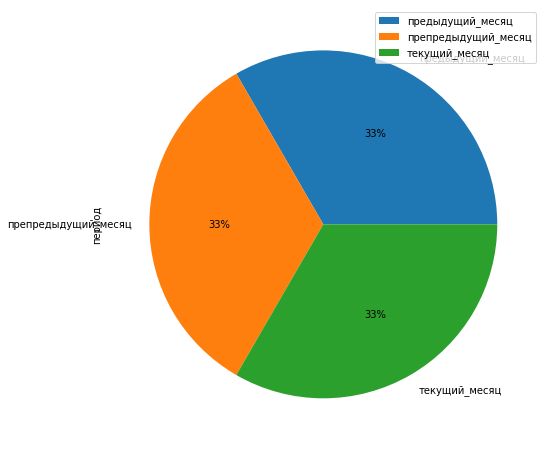

In [63]:
pie(market_money['период'])

Период представлен в равных долях на каждого клиента

Проанализируем сотлбец `выручка`

In [64]:
market_money['выручка'].describe()

count      3891.000000
mean       5033.718890
std        1768.471286
min        2758.700000
25%        4592.000000
50%        4959.000000
75%        5363.200000
max      106862.200000
Name: выручка, dtype: float64

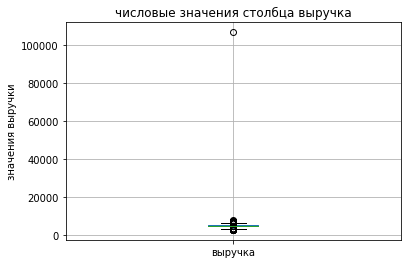

In [65]:
market_money.boxplot(column='выручка')
plt.title('числовые значения столбца выручка')
plt.ylabel('значения выручки')
plt.show()

Найдено аномальное значение, возможно ошибка или был дорогой товар, или много товаров. Заменим значение на медианное

In [66]:
median_money = market_money['выручка'].median()
median_money

4959.0

In [67]:
market_money.loc[market_money['выручка'] > 20000, 'выручка'] = median_money

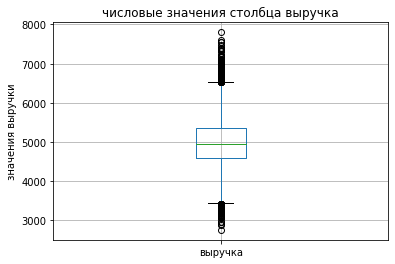

In [68]:
market_money.boxplot(column='выручка')
plt.title('числовые значения столбца выручка')
plt.ylabel('значения выручки')
plt.show()

Посмотрим как распределены значения

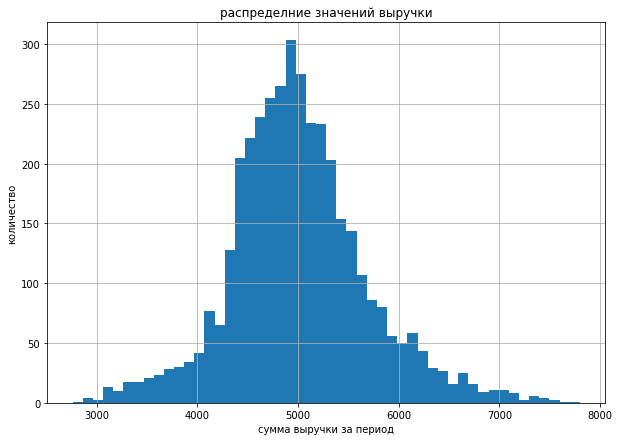

In [69]:
market_money['выручка'].hist(bins=50, figsize=(10,7))
plt.title('распределние значений выручки')
plt.xlabel('сумма выручки за период')
plt.ylabel('количество')
plt.show()

Значения распределны номрально

## Исследовательский анализ датасета `market_money`. Промежуточный вывод:
 - В столбце `период` 3 значения на каждого клиента в равном соотношении:
   - текущий_месяц
   - предыдущий_месяц
   - препредыдущий_месяц
 - В столбце `выручка`:
   - Было выявлено аномальное значение - сумма выручки за период 106862.200000, значение заменил на медианное
   - После замены аномального значения:
     - Сумма выручка за период составляет от 2758.70 до  7799.40
     - Среднее - 5007.52
     - Медиана - 4959.00
   - Значения распределены нормально

### Исследовательский анализ датасета `market_time`

Проанализируем столбец `период`

((<AxesSubplot:ylabel='период'>,),
 предыдущий_месяц    1297
 текущий_месяц       1297
 Name: период, dtype: int64)

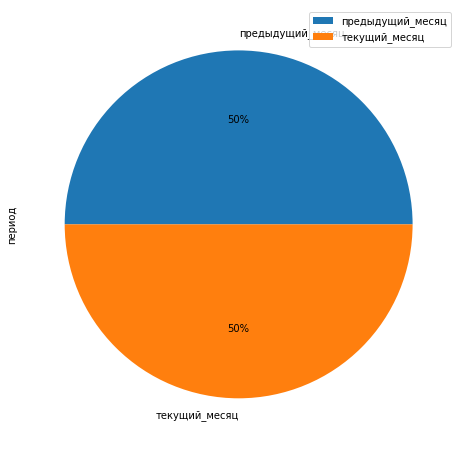

In [70]:
pie(market_time['период'])

В датасете наблюдения представлены за два периода:
 - предыдущий_месяц
 - текущий_месяц
 - значения распределны поровну

In [71]:
market_time.head(1)

,id,период,минут
0,215349,текущий_месяц,10


Проанализируем столбец `минут`

In [72]:
market_time['минут'].describe()

count    2594.000000
mean       13.340401
std         4.081999
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

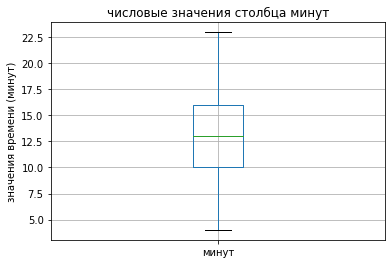

In [73]:
market_time.boxplot(column='минут')
plt.title('числовые значения столбца минут')
plt.ylabel('значения времени (минут)')
plt.show()

Посмотрим на распределние значений 

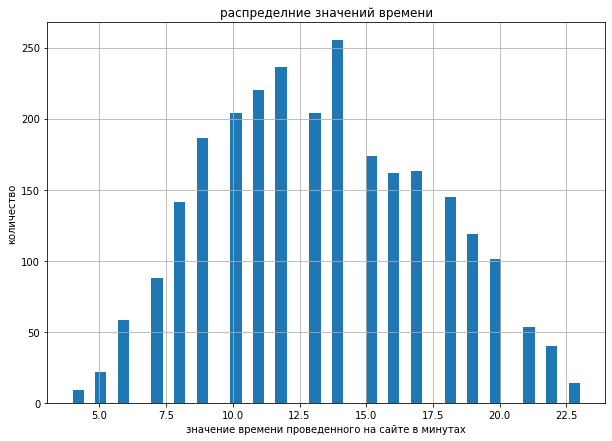

In [74]:
market_time['минут'].hist(bins=45, figsize=(10,7))
plt.title('распределние значений времени')
plt.xlabel('значение времени проведенного на сайте в минутах')
plt.ylabel('количество')
plt.show()

В столбце `минут`:
 - Клиенты проводят на сайте от 4 до 23 минут
 - В среднем - 13 минут
 - Выбросов и аномалий не обнаружено
 - Значения распределены нормально

## Исследовательский анализ датасета `market_time`. Промежуточный вывод:
 - В датасете наблюдения представлены за два периода:
   - предыдущий_месяц
   - текущий_месяц
   - значения распределны поровну
 - В столбце `минут`:
   - Клиенты проводят на сайте от 4 до 23 минут
   - В среднем - 13 минут
   - Выбросов и аномалий не обнаружено
   - Значения распределены нормально

### Исследовательский анализ датасета `money`

In [75]:
money.head(1)

,id,прибыль
0,215349,4.16


Проведем анализ столбца `прибыль`

In [76]:
money['прибыль'].describe()

count    1297.000000
mean        3.997610
std         1.010813
min         0.860000
25%         3.300000
50%         4.040000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

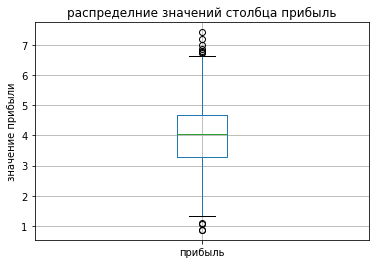

In [77]:
money.boxplot(column='прибыль')
plt.title('распределние значений столбца прибыль')
plt.ylabel('значение прибыли')
plt.show()

Посмотрим на распределние

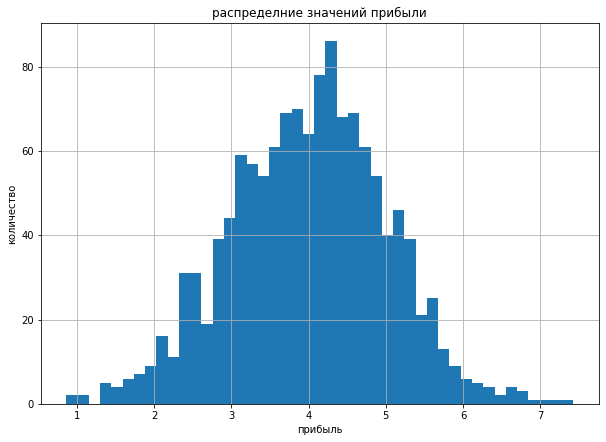

In [78]:
money['прибыль'].hist(bins=45, figsize=(10,7))
plt.title('распределние значений прибыли')
plt.xlabel('прибыль')
plt.ylabel('количество')
plt.show()

## Исследовательский анализ датасета `market_time`. Промежуточный вывод:
 - В столбце `прибыль`:
  - Прибыль распределена нормально от 0.86 до 7.43
  - Есть выбивающиеся значения но они сильно не вляиют на среднее

# Шаг 3. Исследовательский анализ данных. Вывод:
 - Перед началом исследовательского анализа убрали из всех датасетов клиентов с покупательской активностью менее трёх месяцев, то есть таких, которые не покупали в периоды - предыдущий_месяц и предпредыдущий_месяц
 - Провел исследовательский анализ по каждому столбцу:
- Датасет `market_file`
  - Проверял числовые значения, распределения количества, процентные соотношения по категориям
 - Столбец `покупательская_активность`:
   - В категории `снизилась` - 495 клиентов (38%)
   - В категории `прежний уровень` - 802 клента (62%)
 - Столбец `тип_сервиса`:
   - В категории `стандарт` - 922 клиента (71%)
   - В категории `премиум` - 375 клентов (29%)
 - Столбец `разрешить_сообщать`:
   - В категории `да` - 959 клиентов (74%)
   - В категории `нет` - 338 клентов (26%)
 - Столбец `маркет_актив_6_мес`:
   - Среднее - 4.25
   - Медиана - 4.20
   - Есть несколько выбросов 
   - Среднее и медиана близки друг к другу, а значит выбросы не так сильно влияют
 - Столбец `маркет_актив_тек_мес`:
   - Среднее - 4.009
   - Медиана - 4.0
   - Есть выбросы не при их удалении мы лишаемся почти половины данных, оставим без изменений, к тому же они почти не влияют на среднее по сравненнию с медианой
 - Столбец `длительность`:
   - Среднее - 602.99
   - Медиана - 607.00
   - Выбросов и аномалий не обнаружено
   - Время с момента регистриации клиента на сайте показывает что в сервисе уже полгода нет новых пользователей
 - Столбец `акционные_покупки`:
   - Есть выбросы, но думаю их оставить так как люди часто покупают товары по скидкам и акциям, к тому же на сервисе может быть много акционных предложений
   - Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев в основном составляет примерно 20%
 - Столбец `популярная_категория`:
   - Категория - `товары дял детей`, самая популярная - 329 (25%)
 
   - Категория - `домашний текстиль`, в количестве - 250 (19%)
 
   - Категория - `косметика и аксессуары`, в количестве - 223 (17%)
 
   - Категория - `техника для красоты и здоровья`, в количестве - 183 (14%)
 
   - Категория - `мелкая бытовая техника и электроника`, в количестве - 174 (13%)
 
   - Категория - `кухонная посуда`, в количестве - 138 (11%)
 - Столбец `средний_просмотр_категорий_за_визит`:
   - В течении последнего месяца, в среднем клиенты просматривают от 2 до 5 категорий за визит
 - Столбец `неоплаченные_продукты_штук_квартал`
   - За последние 3 месяца большинство клиентов не оплатили 3 товара в корзине
 - Столбец `ошибка_сервиса`:
   - У большинства клиентов число сбоев от 2 до 6
   - Выбросов и аномалий не обнаружено
 - Столбец `страниц_за_визит`
   - В основном клиенты просматривают от 3 до 12 странниц за визит
 - Датасет `market_money`
  - В столбце `период` 3 значения на каждого клиента в равном соотношении:
   - текущий_месяц
   - предыдущий_месяц
   - препредыдущий_месяц
 - В столбце `выручка`:
   - Было выявлено аномальное значение - сумма выручки за период 106862.200000, значение заменил на медианное
   - После замены аномального значения:
     - Сумма выручка за период составляет от 2758.70 до  7799.40
     - Среднее - 5007.52
     - Медиана - 4959.00
   - Значения распределены нормально
 - Датасет `market_time`
  - В датасете наблюдения представлены за два периода:
   - предыдущий_месяц
   - текущий_месяц
   - значения распределны поровну
 - В столбце `минут`:
   - Клиенты проводят на сайте от 4 до 23 минут
   - В среднем - 13 минут
   - Выбросов и аномалий не обнаружено
   - Значения распределены нормально
 - Датасет `money`
  - В столбце `прибыль`:
  - Прибыль распределена нормально от 0.86 до 7.43
  - Есть выбивающиеся значения но они сильно не вляиют на среднее

# Шаг 4. Объединение таблиц

Объединим таблицы `market_file`, `market_time`, `market_money` в таблицу - `market`

Сначала сделаем в каждом датасете `id` - индексом

In [79]:
market_file = market_file.set_index('id')
market_money = market_money.set_index('id')
market_time = market_time.set_index('id')
display(market_file.head())
display(market_money.head())
display(market_time.head())

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
id,,,,,,,,,,,,
215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5
215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5
215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4
215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2
215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4


,период,выручка
id,,
215349,препредыдущий_месяц,4472.0
215349,текущий_месяц,4971.6
215349,предыдущий_месяц,5216.0
215350,препредыдущий_месяц,4826.0
215350,текущий_месяц,5058.4


,период,минут
id,,
215349,текущий_месяц,10
215349,предыдущий_месяц,12
215350,текущий_месяц,13
215350,предыдущий_месяц,8
215351,текущий_месяц,13


Для кажого периода создадим новые столбцы с временем и выручкой

In [80]:
money_pivot = market_money.pivot_table(index='id', columns='период', values=['выручка'])
money_pivot.columns = ['выручка_за_предыдущий_месяц', 'выручка_за_предпредыдущий_месяц', 'выручка_за_текущий_месяц']
money_pivot.head()

,выручка_за_предыдущий_месяц,выручка_за_предпредыдущий_месяц,выручка_за_текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5


In [81]:
time_pivot = market_time.pivot_table(index='id', columns='период', values='минут')
time_pivot.columns = ['минут_за_предыдущий_месяц', 'минут_за_текущий_месяц']
time_pivot.head()

,минут_за_предыдущий_месяц,минут_за_текущий_месяц
id,,
215349,12,10
215350,8,13
215351,11,13
215352,8,11
215353,10,10


In [82]:
market = market_file.join(money_pivot)
market = market.join(time_pivot)
market.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_предпредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [83]:
rep(market)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1297 non-null   object 
 1   тип_сервиса                          1297 non-null   object 
 2   разрешить_сообщать                   1297 non-null   object 
 3   маркет_актив_6_мес                   1297 non-null   float64
 4   маркет_актив_тек_мес                 1297 non-null   int64  
 5   длительность                         1297 non-null   int64  
 6   акционные_покупки                    1297 non-null   float64
 7   популярная_категория                 1297 non-null   object 
 8   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 10  ошибка_сервиса                       1297 non-null   int64  
 11  страниц_за_визит       

(None,
 покупательская_активность              0
 тип_сервиса                            0
 разрешить_сообщать                     0
 маркет_актив_6_мес                     0
 маркет_актив_тек_мес                   0
 длительность                           0
 акционные_покупки                      0
 популярная_категория                   0
 средний_просмотр_категорий_за_визит    0
 неоплаченные_продукты_штук_квартал     0
 ошибка_сервиса                         0
 страниц_за_визит                       0
 выручка_за_предыдущий_месяц            0
 выручка_за_предпредыдущий_месяц        0
 выручка_за_текущий_месяц               0
 минут_за_предыдущий_месяц              0
 минут_за_текущий_месяц                 0
 dtype: int64)

In [84]:
len(market) == len(market_file)

True

In [85]:
market.duplicated().sum()

11

В новой таблице обнаружены дубликаты, посмотрим

In [86]:
market[market.duplicated(keep=False)]

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_предпредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц
id,,,,,,,,,,,,,,,,,
215685,снизилась,стандарт,нет,4.4,5,517,0.23,товары для детей,1,2,5,11,3130.0,4382.0,4345.5,11,12
215686,снизилась,стандарт,нет,4.3,4,460,0.16,техника для красоты и здоровья,2,1,3,6,4828.0,4822.0,4952.8,13,9
215687,снизилась,стандарт,да,3.9,4,627,0.24,товары для детей,3,3,7,8,5004.5,4460.0,5606.4,17,12
215688,снизилась,стандарт,да,5.5,4,703,0.14,мелкая бытовая техника и электроника,2,1,3,7,3428.0,4346.0,4353.6,18,11
215689,снизилась,стандарт,нет,5.0,4,136,0.27,товары для детей,3,4,4,17,4998.0,5230.0,5329.5,11,18
215690,снизилась,стандарт,да,4.8,4,907,0.30,косметика и аксесуары,2,1,1,6,5005.5,5241.0,4931.4,13,14
215691,снизилась,стандарт,нет,3.9,5,600,0.17,домашний текстиль,1,7,4,10,4606.0,5047.0,4353.8,18,20
215692,снизилась,стандарт,да,3.3,3,871,0.20,техника для красоты и здоровья,2,4,2,17,5439.0,4818.0,6107.2,17,8
215693,снизилась,стандарт,да,5.6,5,574,0.28,домашний текстиль,3,2,3,9,4502.0,4483.0,4615.1,16,6


Не смотря на то что дубликаты различаются по `id`, удалим дубликаты

In [87]:
market.drop_duplicates(inplace=True)

In [88]:
market.duplicated().sum()

0

# Шаг 4. Объединение таблиц. Промежуточный вывод:
 - В каждом датасете сделал `id` - индксом
 - Из датафрема `market_money` сделал свобдную таблицу со значением выручки по каждому периоду для каждого клиента
 - Из датафрейма `market_money` сделал содную таблицу со значением продолжительности посещения сайта на кждый период для каждого клиента
 - Объединил датасеты - `market_file`, `market_money`, `market_time` в новую таблицу `market`
 - Новая таблица `market` совпадает c количествоv строк таблицы `market_file`
 - В новом датасете отсутствуют пропуски
 - Обнаружены дубликаты, удалил

# Шаг 5. Корреляционный анализ

Построим матрицу корреляции

In [89]:
market.head(1)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_предпредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10


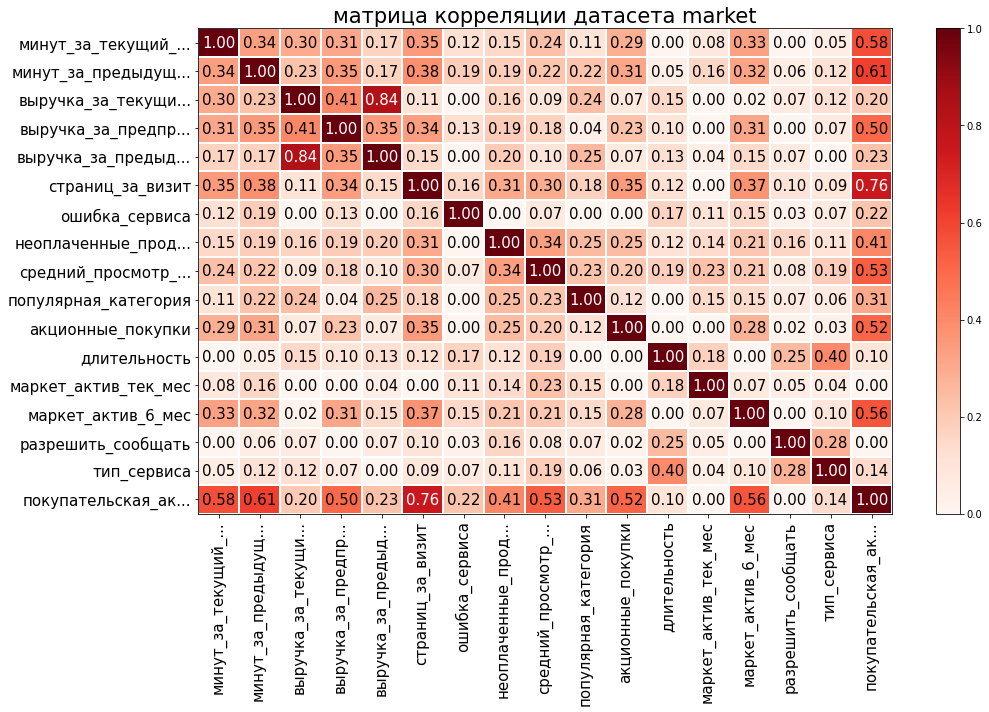

In [90]:
interval_cols = ['длительность', 'маркет_актив_6_мес',
                'маркет_актив_тек_мес', 'акционные_покупки',
                'выручка_за_предыдущий_месяц',
                'выручка_за_предпредыдущий_месяц',
                'выручка_за_текущий_месяц',
                ]

market_phik = market.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(market_phik.values,
                       x_labels=market_phik.columns,
                       y_labels=market_phik.index,
                       vmin=0, vmax=1, color_map='Reds',
                       title='матрица корреляции датасета market',
                       fontsize_factor=1.5, figsize=(15,10)
                       )

# Шаг 5. Корреляционный анализ. Промежуточный вывод:
По матрице корреляции видно что:
 - Мультиколлениарность отсутвует
 - С целевым признаком `покупательская_активность`:
 
   - сильная корреляция с толбцом: `страниц_за_визит`
   
   - средняя корреляция с толбцами: `маркет_актив_6_мес`, `акционные_покупки`, `средний_просмотр_категорий_за_визит`, `выручка_за_предпредыдущий_месяц`, `минут_за_предыдущий_месяц`, `минут_за_текущий_месяц`
   
 - У признаков `выручка_за_текущий_месяц` и `выручка_за_предыдущий_месяц` сильная корреляция

# Шаг 6. Использование пайплайнов

Перед созданием пайплана, преобразуем целевой признак `покупательская_активность`: значение `снизилось` - `1`, `прежний уровень` - `0`

In [91]:
le = LabelEncoder()
market['покупательская_активность'] = le.fit_transform(market['покупательская_активность'])

In [92]:
market['покупательская_активность'].value_counts()

0    802
1    484
Name: покупательская_активность, dtype: int64

Наблюдается дисбаланс классов, учтем это при создании выборок

Разобьем данные на тренировочную и тестовую выборку, объявим константы, укажем стратификацию

In [93]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
X = market.drop(['покупательская_активность'], axis=1)
y = market['покупательская_активность']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    random_state=RANDOM_STATE, test_size=TEST_SIZE, stratify=y)

Создадим списки с категорильными и количественными признаками 

In [94]:
ohe_columns = ['популярная_категория']
ord_columns = ['тип_сервиса', 'разрешить_сообщать']

In [95]:
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
               'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал',
               'ошибка_сервиса', 'страниц_за_визит', 'выручка_за_предыдущий_месяц',
               'выручка_за_предпредыдущий_месяц', 'выручка_за_текущий_месяц',
               'минут_за_предыдущий_месяц', 'минут_за_текущий_месяц']

Начнем создание пайплайна

### Пайплайн для кодирования методом `OneHotEncoder`

In [96]:
ohe_pipe = Pipeline(
    [
        (
        'simpleimputer_ohe',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
        'ohe',
        OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
        )
        
    ]
)

### Пайплайн для кодирования методом `OrdinalEncoder`

In [97]:
ord_pipe = Pipeline(
    [
        (
        'simpleimputer_before_ord',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
        'ord',
        OrdinalEncoder(
                       handle_unknown='use_encoded_value', unknown_value=np.nan
                      )
        ),
        (
        'simpleimputer_after_ord',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )

    ]
)

Объеденим пайплайны для подготовки данных

In [98]:
data_preprocessor = ColumnTransformer(
    [
        ['ohe', ohe_pipe, ohe_columns],
        ['ord', ord_pipe, ord_columns],
        ['num', StandardScaler(), num_columns]
    
    ],
    remainder='passthrough'
)

Создадим итоговый пайплайн где будем перебирать модели, методы масштабирования и гиперпараметры

In [99]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [170]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()] ,
        'models__n_neighbors': range(2,40),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1,6),
        'models__penalty': ['l1', 'l2'],
        'models__solver': ['liblinear', 'saga'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1,6),
        'models__kernel': ['rdf', 'sigmoid', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

Используем подбор параметров модели способом Рандомной оптимизации

In [171]:
randomized_search = RandomizedSearchCV(pipe_final,
                               param_grid,
                               scoring='roc_auc',
                               cv=5,
                               n_jobs=-1,
                               random_state=RANDOM_STATE
                              )
randomized_search.fit(X_train, y_train)
print('Лушчая модель и ее параметры:', randomized_search.best_estimator_)

print('Метрика лучшей модели при кросс-валидации:', randomized_search.best_score_)

Лушчая модель и ее параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleimputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleimputer_before_ord',
             

# Шаг 6. Использование пайплайнов. Промежуточный вывод:
 - Перед созданием пайплана, преобровал целевой признак `покупательская_активность`: значение `снизилось` - `0`, `прежний уровень` - `1`
 - В целевом признаке наблюдается дисбаланс классов
 - При разбивке данных на тренировочную и тестовую выборки, был учтен дисбаланс классов
 - Закодировал методами `OneHotEncoder` и `OrdinalEncoder` категориальные признаки
 - Стандиртизировал количественные признаки
 - Создал пайплан для подготовки данных
 - Создал пайплайн, где перебираются разные модели и их гиперпараметры
 - Для оценки качества модели выбрал метрику - `roc_auc`, так как эта метрика лучше всего подходит для оценки качества модели бинарной классификации
 - В итоге была отобрана лучшая модель - `KNeighborsClassifier` с параметрами: `n_neighbors=22` и метрикой `roc_auc=0.915` при кросс-валдации
 - Проведена проверка модели на адекватность:
   - Можно точно сказать что полученная нами модель делает предсказания не случайно

In [127]:
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)
dummy_model_preds = dummy_model.predict(X_test)
print('accuracy:', accuracy_score(y_test, dummy_model_preds))
print('roc_auc:', roc_auc_score(y_test, dummy_model_preds))

accuracy: 0.6242236024844721
roc_auc: 0.5


# Шаг 7. Анализ важности признаков

Сохрнаим лучшую модель в переменную

In [128]:
best_model = randomized_search.best_estimator_
knn_model = best_model.named_steps['models']

Преобразуем входные признаки

In [129]:
X_train_transformed = best_model.named_steps['preprocessor'].fit_transform(X_train)
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

In [130]:
test_pred = knn_model.predict(X_test_transformed)
print('Метрика лучшей модели на тестовой выборке:', roc_auc_score(y_test, test_pred))

Метрика лучшей модели на тестовой выборке: 0.8825706179844578


In [131]:
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
feature_names

array(['ohe__популярная_категория_косметика и аксесуары',
       'ohe__популярная_категория_кухонная посуда',
       'ohe__популярная_категория_мелкая бытовая техника и электроника',
       'ohe__популярная_категория_техника для красоты и здоровья',
       'ohe__популярная_категория_товары для детей', 'ord__тип_сервиса',
       'ord__разрешить_сообщать', 'num__маркет_актив_6_мес',
       'num__маркет_актив_тек_мес', 'num__длительность',
       'num__акционные_покупки',
       'num__средний_просмотр_категорий_за_визит',
       'num__неоплаченные_продукты_штук_квартал', 'num__ошибка_сервиса',
       'num__страниц_за_визит', 'num__выручка_за_предыдущий_месяц',
       'num__выручка_за_предпредыдущий_месяц',
       'num__выручка_за_текущий_месяц', 'num__минут_за_предыдущий_месяц',
       'num__минут_за_текущий_месяц'], dtype=object)

  0%|          | 0/322 [00:00<?, ?it/s]

Text(0.5, 1.0, 'оценка важности признаков')

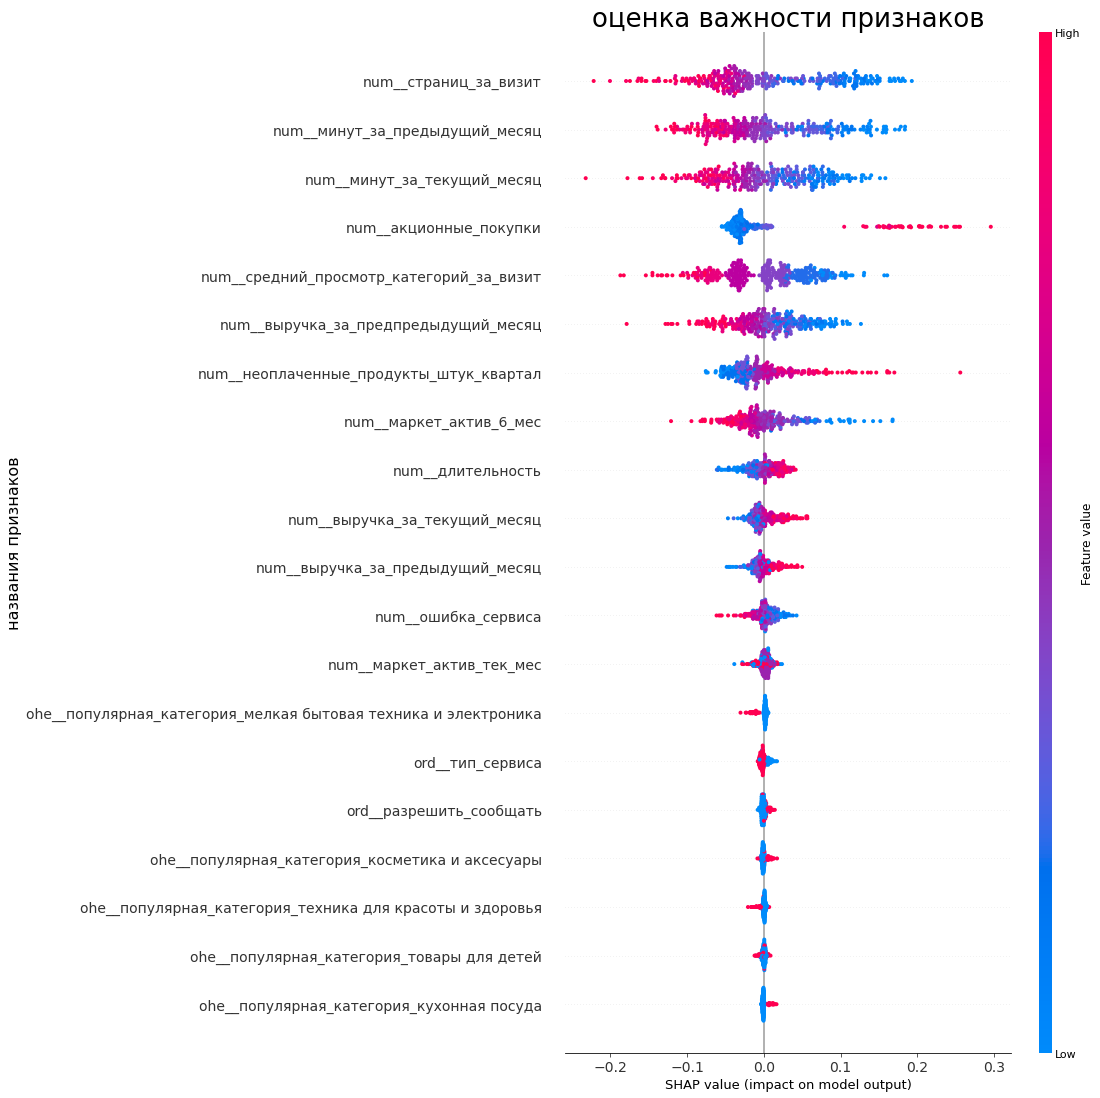

In [107]:
X_train_df = pd.DataFrame(
    X_train_transformed,
    columns=feature_names
)

X_test_df = pd.DataFrame(
    X_test_transformed,
    columns=feature_names
)

explainer = shap.SamplingExplainer(
    lambda x: knn_model.predict_proba(x)[:,1],
    X_train_transformed)

shap_values = explainer.shap_values(X_test_df)
shap.summary_plot(shap_values, X_test_df, plot_size=(15,15), show=False)
fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=14)
ax.set_ylabel('названия признаков', size=16)
ax.set_title('оценка важности признаков', size=26)

# Шаг 7. Анализ важности признаков. Промежуточный вывод:
 - Малозначимые признаки для прогноза модели:
  - `популярная_категория`, `маркет_актив_тек_мес`
 - Сильнее всего на целевой признак влияют: 
  - `страниц_за_визит`, `минут_за_предыдущий_месяц`, `минут_за_текущий_месяц`, `акционные_покупки`, `средний_просмотр_категорий_за_визит`, `выручка_за_предпредыдущий_месяц`, `неоплаченные_продукты_штук_квартал`, `маркет_актив_6_мес`
 - Влияние на целевой признак по графику Шепли:
   - `страниц_за_визит` - чем больше значение признака, тем с большей вероятностью модель отнесет клиента к классу 0 (прежний уровень)
   - `минут_за_текущий_месяц` - чем больше значение этого признака, тем больше вероятность отнести такого пользователя к классу 0 (прежний уровень)
   - `акционные_покупки` - представлено более наглядно, при увелечении значения признака. вероятность принадлежности к классу 1(снизилась) увеличивается
   - `неоплаченные_продукты_штук_квартал` - говорит о том, что при увелечении числа неоплаченных продуктов, увеличивается верояность принадлежности к классу 1(снизилась)

# Шаг 8. Сегментация покупателей



Добавим к тестовой выборке предсказания модели и вероятности принадлежности к классу

In [132]:
y_pred = knn_model.predict(X_test_transformed)
y_preds = 1-knn_model.predict_proba(X_test_transformed)[:,1]
X_test['y_pred'] = y_pred
X_test['y_preds'] = y_preds

In [133]:
X_test.sort_values(by='y_preds', ascending=False)

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_предпредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц,y_pred,y_preds,прибыль
120,215775,стандарт,нет,5.0,4,157,0.15,мелкая бытовая техника и электроника,5,0,5,13,4028.0,4934.0,3372.8,19,16,0,0.996398,1.38
189,215823,стандарт,нет,5.0,5,234,0.23,техника для красоты и здоровья,5,1,7,13,5153.0,5600.0,4895.6,21,15,0,0.995488,5.42
246,216410,премиум,да,4.8,3,939,0.11,домашний текстиль,6,1,7,12,4273.0,4465.0,4236.6,21,23,0,0.992595,4.74
234,216070,премиум,да,3.9,4,379,0.24,мелкая бытовая техника и электроника,4,1,4,11,4010.5,4771.0,3481.4,19,21,0,0.986848,3.27
59,215862,стандарт,да,5.8,4,408,0.16,мелкая бытовая техника и электроника,4,2,3,12,5330.0,5222.0,5553.6,12,21,0,0.986152,5.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,215667,премиум,да,3.0,4,467,0.95,косметика и аксесуары,2,6,7,3,5159.0,4544.0,5424.2,8,8,1,0.009214,3.70
125,215705,премиум,нет,0.9,4,657,0.99,домашний текстиль,2,4,2,5,5055.5,4568.0,5522.2,10,7,1,0.008033,4.30
46,215418,стандарт,нет,1.7,4,472,0.94,домашний текстиль,2,6,4,3,5943.5,4661.0,6427.1,8,11,1,0.007191,4.98
232,215433,стандарт,да,4.0,4,753,0.89,товары для детей,2,8,3,2,4599.0,4098.0,4959.1,8,11,1,0.006292,3.65


Объеденим тестовую выборку и датасет `money` по индксу (`id`)

In [134]:
X_test = X_test.merge(money, on='id', how='left')
X_test.sort_values(by='y_preds', ascending=False)

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,...,страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_предпредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц,y_pred,y_preds,прибыль_x,прибыль_y
120,215775,стандарт,нет,5.0,4,157,0.15,мелкая бытовая техника и электроника,5,0,...,13,4028.0,4934.0,3372.8,19,16,0,0.996398,1.38,1.38
189,215823,стандарт,нет,5.0,5,234,0.23,техника для красоты и здоровья,5,1,...,13,5153.0,5600.0,4895.6,21,15,0,0.995488,5.42,5.42
246,216410,премиум,да,4.8,3,939,0.11,домашний текстиль,6,1,...,12,4273.0,4465.0,4236.6,21,23,0,0.992595,4.74,4.74
234,216070,премиум,да,3.9,4,379,0.24,мелкая бытовая техника и электроника,4,1,...,11,4010.5,4771.0,3481.4,19,21,0,0.986848,3.27,3.27
59,215862,стандарт,да,5.8,4,408,0.16,мелкая бытовая техника и электроника,4,2,...,12,5330.0,5222.0,5553.6,12,21,0,0.986152,5.41,5.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,215667,премиум,да,3.0,4,467,0.95,косметика и аксесуары,2,6,...,3,5159.0,4544.0,5424.2,8,8,1,0.009214,3.70,3.70
125,215705,премиум,нет,0.9,4,657,0.99,домашний текстиль,2,4,...,5,5055.5,4568.0,5522.2,10,7,1,0.008033,4.30,4.30
46,215418,стандарт,нет,1.7,4,472,0.94,домашний текстиль,2,6,...,3,5943.5,4661.0,6427.1,8,11,1,0.007191,4.98,4.98
232,215433,стандарт,да,4.0,4,753,0.89,товары для детей,2,8,...,2,4599.0,4098.0,4959.1,8,11,1,0.006292,3.65,3.65


Так как цель проекта:
 - персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.
  - Отберем из тестовой выборки клиентов у которых предсказания модели `y_pred == 0(прежний уровень)`
  - Проведем исследовательский анализ этой группы клиентов 
  

Для наглядности раскодируем стобец `y_pred`:
 - 0 - `снизилась`
 
 - 1 - `прежний уровень`

In [140]:
X_test['y_pred'] = (
    X_test['y_pred'].apply(
        lambda x: 'снизилась' if x == 1 else 'прежний уровень')
)

In [141]:
prev_level = X_test.query('y_pred == "прежний уровень"')
prev_level

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,...,страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_предпредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц,y_pred,y_preds,прибыль_x,прибыль_y
0,216600,премиум,да,4.4,4,349,0.40,домашний текстиль,5,4,...,8,4748.0,4625.0,4510.1,17,17,прежний уровень,0.805751,3.64,3.64
1,216243,стандарт,да,3.3,5,812,0.11,косметика и аксесуары,4,1,...,5,4438.0,5485.0,3660.6,12,19,прежний уровень,0.846871,2.79,2.79
2,215736,премиум,да,5.6,3,540,0.36,косметика и аксесуары,2,4,...,8,5049.0,4734.0,5168.6,8,11,прежний уровень,0.260937,3.43,3.43
3,216595,стандарт,да,4.2,4,753,0.94,косметика и аксесуары,6,2,...,10,4766.5,4522.0,5108.4,9,17,прежний уровень,0.494224,3.09,3.09
4,216259,премиум,да,4.7,5,150,0.14,товары для детей,3,1,...,20,4248.0,5077.0,5096.9,15,9,прежний уровень,0.973496,4.30,4.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,216546,премиум,да,4.7,4,475,0.26,косметика и аксесуары,2,3,...,14,3155.0,5154.0,3457.9,15,14,прежний уровень,0.875007,4.04,4.04
318,216238,стандарт,да,4.0,4,693,0.27,кухонная посуда,3,0,...,4,5042.5,4894.0,5301.2,18,16,прежний уровень,0.772375,4.62,4.62
319,215782,стандарт,да,5.2,3,457,0.17,товары для детей,4,1,...,5,5597.0,5624.0,5750.4,12,10,прежний уровень,0.827603,4.48,4.48
320,216063,премиум,да,5.2,4,982,0.28,техника для красоты и здоровья,2,2,...,12,4074.0,4479.0,4555.0,15,22,прежний уровень,0.911769,2.54,2.54


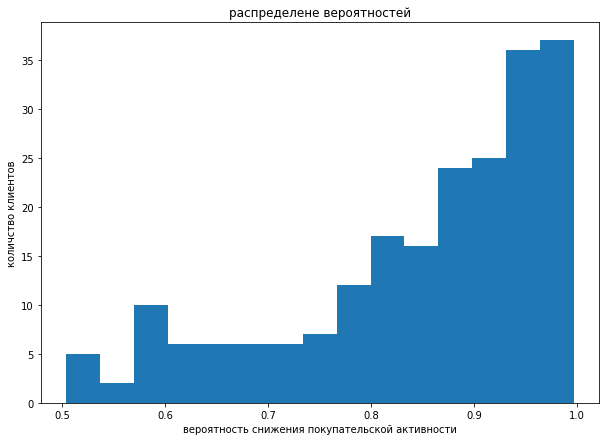

In [137]:
plt.figure(figsize=(10,7))
plt.hist(prev_level['y_preds'], bins=15)
plt.title('распределене вероятностей')
plt.xlabel('вероятность снижения покупательской активности')
plt.ylabel('количство клиентов')
plt.show()

В полученном датасете `prev_level` получили 219 клиентов с вероятностью снижения покупательской активности от 50%, отберем клиентов с вероятностью от 70%

In [138]:
prev_level = prev_level.query('y_preds>=0.7')
prev_level

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,...,страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_предпредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц,y_pred,y_preds,прибыль_x,прибыль_y
0,216600,премиум,да,4.4,4,349,0.40,домашний текстиль,5,4,...,8,4748.0,4625.0,4510.1,17,17,прежний уровень,0.805751,3.64,3.64
1,216243,стандарт,да,3.3,5,812,0.11,косметика и аксесуары,4,1,...,5,4438.0,5485.0,3660.6,12,19,прежний уровень,0.846871,2.79,2.79
4,216259,премиум,да,4.7,5,150,0.14,товары для детей,3,1,...,20,4248.0,5077.0,5096.9,15,9,прежний уровень,0.973496,4.30,4.30
5,216411,стандарт,да,5.1,4,602,0.23,товары для детей,2,2,...,9,4857.0,4775.0,4915.5,17,15,прежний уровень,0.830009,3.26,3.26
6,216033,стандарт,да,5.4,4,387,0.11,техника для красоты и здоровья,2,2,...,11,4403.0,5043.0,5088.1,15,16,прежний уровень,0.947744,5.29,5.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,216546,премиум,да,4.7,4,475,0.26,косметика и аксесуары,2,3,...,14,3155.0,5154.0,3457.9,15,14,прежний уровень,0.875007,4.04,4.04
318,216238,стандарт,да,4.0,4,693,0.27,кухонная посуда,3,0,...,4,5042.5,4894.0,5301.2,18,16,прежний уровень,0.772375,4.62,4.62
319,215782,стандарт,да,5.2,3,457,0.17,товары для детей,4,1,...,5,5597.0,5624.0,5750.4,12,10,прежний уровень,0.827603,4.48,4.48
320,216063,премиум,да,5.2,4,982,0.28,техника для красоты и здоровья,2,2,...,12,4074.0,4479.0,4555.0,15,22,прежний уровень,0.911769,2.54,2.54


Получили 199 клиентов с вероятностью снижения покупательской активности от 70%. Проанализируем эту группу клиентов

Посмотрим как распределена прибыль

In [139]:
plt.figure(figsize=(10,7))
plt.hist(prev_level['прибыль'], bins=20)
plt.title('распределние прибыли')
plt.xlabel('прибыль')
plt.ylabel('количство клиентов')
plt.show()

KeyError: 'прибыль'

<Figure size 720x504 with 0 Axes>

In [ ]:
prev_level['прибыль'].describe()

In [ ]:
prev_level.boxplot(column='прибыль')

Значение прибыли распределно нормально:
 - В основном значение прибыли составляет от 3.25 до 5.0
 - Среднее значение прибыли - 4.0

Посмотрим на популярные категории

In [ ]:
barh(prev_level, column='популярная_категория');

Исходя из анализа столбца `популярная_категория` видно что чаще всего интересуются категориями:
 - товары для детей
 - домашний текстиль
 - мелвкая бытовая техника и электроника
 - техника для красоты и здоровья
 - косметика и аксессуары
Можно предлагать персональные скидки и акции на эти категории товаров для отдельных клиентов

# Общий вывод:
 - Были получены 4 датасета:
  - `market_file` - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
   
  - `market_time` - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
   
  - `market_money` - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
   
  - `money` - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
   
  - Данные в таблицах соответсвуют их описанию
 -  Предобработка данных:
  - В процессе предобработки данных было сделано:
   - Привел все столбцы в датасетах к нижнему "змеиному регистру"
   - Для удобства привел к нижнему регистру значения в столбцах - `покупательская_активность` и `популярная_категория` датасета `market_file`
   - Проверил во всех датасетах пропуски, дубликаты, типы данных:
     - В датасете `market_file` обнаружены неподходящие типы данных в столбцах: `маркет_актив_6_мес` и `акционные_покупки`, изменил их на тип `float`
     - В датасете `market_money` обнаружен неподходящий тип данных в столбце `выручка`, изменил тип данных на `float`
     - В во всех датасетах не обнаружено пропусков и дубликатов
   - Проверил уникальные значения в каждом столбце каждого датасета:
     - Были проверены в основном категориальные столбцы и колличественные с небольшим числом уникальных значений, так как эти значения мы проверим на шаге исследовательского анализа данных
     - В датасете `market_file` в столбце `тип_сервиса` обнаружена ошибка в категории - `стандартт` изменил на `стандарт`
     - В датасете `market_time` в значении столбца `период` обнаружена орфографическая ошибка, исправил
 - Исследовательский анализ данных:
 - Перед началом исследовательского анализа убрали из всех датасетов клиентов с покупательской активностью менее трёх месяцев, то есть таких, которые не покупали в периоды - предыдущий_месяц и предпредыдущий_месяц
 - Провел исследовательский анализ по каждому столбцу:
- Датасет `market_file`
  - Проверял числовые значения, распределения количества, процентные соотношения по категориям
 - Столбец `покупательская_активность`:
   - В категории `снизилась` - 495 клиентов (38%)
   - В категории `прежний уровень` - 802 клента (62%)
 - Столбец `тип_сервиса`:
   - В категории `стандарт` - 922 клиента (71%)
   - В категории `премиум` - 375 клентов (29%)
 - Столбец `разрешить_сообщать`:
   - В категории `да` - 959 клиентов (74%)
   - В категории `нет` - 338 клентов (26%)
 - Столбец `маркет_актив_6_мес`:
   - Среднее - 4.25
   - Медиана - 4.20
   - Есть несколько выбросов 
   - Среднее и медиана близки друг к другу, а значит выбросы не так сильно влияют
 - Столбец `маркет_актив_тек_мес`:
   - Среднее - 4.009
   - Медиана - 4.0
   - Есть выбросы не при их удалении мы лишаемся почти половины данных, оставим без изменений, к тому же они почти не влияют на среднее по сравненнию с медианой
 - Столбец `длительность`:
   - Среднее - 602.99
   - Медиана - 607.00
   - Выбросов и аномалий не обнаружено
   - Время с момента регистриации клиента на сайте показывает что в сервисе уже полгода нет новых пользователей
 - Столбец `акционные_покупки`:
  - Есть выбросы, но думаю их оставить так как люди часто покупают товары по скидкам и акциям, к тому же на сервисе может быть много акционных предложений
   - Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев в основном составляет примерно 20%
 - Столбец `популярная_категория`:
   - Категория - `товары дял детей`, самая популярная - 329 (25%)
 
   - Категория - `домашний текстиль`, в количестве - 250 (19%)
 
   - Категория - `косметика и аксессуары`, в количестве - 223 (17%)
 
   - Категория - `техника для красоты и здоровья`, в количестве - 183 (14%)
 
   - Категория - `мелкая бытовая техника и электроника`, в количестве - 174 (13%)
 
   - Категория - `кухонная посуда`, в количестве - 138 (11%)
 - Столбец `средний_просмотр_категорий_за_визит`:
   - В течении последнего месяца, в среднем клиенты просматривают от 2 до 5 категорий за визит
 - Столбец `неоплаченные_продукты_штук_квартал`
   - За последние 3 месяца большинство клиентов не оплатили 3 товара в корзине
 - Столбец `ошибка_сервиса`:
   - У большинства клиентов число сбоев от 2 до 6
   - Выбросов и аномалий не обнаружено
 - Столбец `страниц_за_визит`
   - В основном клиенты просматривают от 3 до 12 странниц за визит
 - Датасет `market_money`
  - В столбце `период` 3 значения на каждого клиента в равном соотношении:
   - текущий_месяц
   - предыдущий_месяц
   - препредыдущий_месяц
 - В столбце `выручка`:
   - Было выявлено аномальное значение - сумма выручки за период 106862.200000, значение заменил на медианное
   - После замены аномального значения:
     - Сумма выручка за период составляет от 2758.70 до  7799.40
     - Среднее - 5007.52
     - Медиана - 4959.00
   - Значения распределены нормально
 - Датасет `market_time`
  - В датасете наблюдения представлены за два периода:
   - предыдущий_месяц
   - текущий_месяц
   - значения распределны поровну
 - В столбце `минут`:
   - Клиенты проводят на сайте от 4 до 23 минут
   - В среднем - 13 минут
   - Выбросов и аномалий не обнаружено
   - Значения распределены нормально
 - Датасет `money`
  - В столбце `прибыль`:
  - Прибыль распределена нормально от 0.86 до 7.43
  - Есть выбивающиеся значения но они сильно не вляиют на среднее
 - Объединение таблиц:
   - В каждом датасете сделал `id` - индксом
   - Из датафрема `market_money` сделал свобдную таблицу со значением выручки по каждому периоду для каждого клиента
   - Из датафрейма `market_money` сделал содную таблицу со значением продолжительности посещения сайта на кждый период для каждого клиента
   - Объединил датасеты - `market_file`, `market_money`, `market_time` в новую таблицу `market`
   - Новая таблица `market` совпадает c количествоv строк таблицы `market_file`
   - В новом датасете отсутствуют пропуски
   - Обнаружены дубликаты, удалил
 - Корреляционный анализ:
По матрице корреляции видно что:
   - Мультиколлениарность отсутвует
   - С целевым признаком `покупательская_активность`:
 
     - сильная корреляция с толбцом: `страниц_за_визит`
   
     - средняя корреляция с толбцами: `маркет_актив_6_мес`, `акционные_покупки`, `средний_просмотр_категорий_за_визит`, `выручка_за_предпредыдущий_месяц`, `минут_за_предыдущий_месяц`, `минут_за_текущий_месяц`
   
   - У признаков `выручка_за_текущий_месяц` и `выручка_за_предыдущий_месяц` сильная корреляция
 - Использование пайплайнов. Промежуточный вывод:
  - Перед созданием пайплана, преобразовал целевой признак `покупательская_активность`: значение `снизилось` - `0`, `прежний уровень` - `1`
  - В целевом признаке наблюдается дисбаланс классов
  - При разбивке данных на тренировочную и тестовую выборки, был учтен дисбаланс классов
  - Закодировал методами `OneHotEncoder` и `OrdinalEncoder` категориальные признаки
  - Стандиртизировал количественные признаки
  - Создал пайплан для подготовки данных
  - Создал пайплайн, где перебираются разные модели и их гиперпараметры
  - Для оценки качества модели выбрал метрику - `roc_auc`, так как эта метрика лучше всего подходит для оценки качества модели бинарной классификации
  - В итоге была отобрана лучшая модель - `KNeighborsClassifier` с параметром `n_neighbors=45` и метрикой `roc_auc=0.918`
 - Анализ важности признаков. Промежуточный вывод:
  - Малозначимые признаки для прогноза модели:
   - `популярная_категория`, `маркет_актив_тек_мес`
  - Сильнее всего на целевой признак влияют: 
   - `страниц_за_визит`, `минут_за_предыдущий_месяц`, `минут_за_текущий_месяц`, `акционные_покупки`, `средний_просмотр_категорий_за_визит`, `выручка_за_предпредыдущий_месяц`, `неоплаченные_продукты_штук_квартал`, `маркет_актив_6_мес`
  - Влияние на целевой признак по графику Шепли:
    - `страниц_за_визит` - чем больше значение признака, тем с большей вероятностью модель отнесет клиента к классу 0 (прежний уровень)
    - `минут_за_текущий_месяц` - чем больше значение этого признака, тем больше вероятность отнести такого пользователя к классу 0 (прежний уровень)
    - `акционные_покупки` - представлено более наглядно, при увелечении значения признака. вероятность принадлежности к классу 1(снизилась) увеличивается
    - `неоплаченные_продукты_штук_квартал` - говорит о том, что при увелечении числа неоплаченных продуктов, увеличивается верояность принадлежности к классу 1(снизилась)
 - Сегментация покупателей:
  - Добавил к тестовой выборке предсказания модели и вероятности снижения покупательской активности
  - Так как цель проекта:
    - персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.
      - Отбрал из тестовой выборки клиентов у которых предсказания модели `y_pred == 0(прежний уровень)`
      - Проведел исследовательский анализ этой группы клиентов
  - В полученном датасете `prev_level` получили 219 клиентов с вероятностью снижения покупательской активности от 50%, отобрал клиентов с вероятностью от 70%
  - Получили 199 клиентов с вероятностью снижения покупательской активности от 70%. Проанализировал эту группу клиентов:
    - Значение прибыли распределно нормально:
      - В основном значение прибыли составляет от 3.25 до 5.0
      - Среднее значение прибыли - 4.0
    - Исходя из анализа столбца `популярная_категория` видно что чаще всего интересуются категориями:
      - товары для детей
      - домашний текстиль
      - мелвкая бытовая техника и электроника
      - техника для красоты и здоровья
      - косметика и аксессуары
# Предложения:
 - Персонализировать предложения для клиентов по популярным категорям
 - C увелечением вероятности снижения покупательской активности повышать количество маркетинговых коммуникаций